In [1]:
from hossam import *

from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

from sklearn.linear_model import Lasso

In [2]:
origin = load_data("fish_processed")
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터의 전처리 버전


,길이,높이,두께,무게
0,8.4,2.11,1.41,1.931521
1,13.7,3.53,2.00,3.496508
2,15.0,3.82,2.43,3.713572
3,16.2,4.59,2.63,3.960813
4,17.4,4.59,2.94,4.262680


In [3]:
df = origin

yname = "무게"
x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42, 3), (14, 3), (42,), (14,))

In [4]:
%%time

pipe = Pipeline([("scaler", StandardScaler()), ("model", Lasso(random_state=52))])

param_grid = {"model__alpha": [0.01, 0.1, 1, 10, 100]}

gs = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring="r2", n_jobs=-1)

gs.fit(x_train, y_train)

estimator = gs.best_estimator_
estimator

CPU times: total: 93.8 ms
Wall time: 2.63 s


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",0.1
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.",False
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True


In [5]:
y_pred = estimator.predict(x_test)

result_df =DataFrame(
    {
        "결정계수(R2)": r2_score(y_test, y_pred),
        "평균절대오차(MSE)":mean_absolute_error(y_test, y_pred),
        "평균제곱오차(MSE)":mean_squared_error(y_test, y_pred),
        "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
        "평균 절대 백분오차 비율(MAPE)": mean_absolute_percentage_error(y_test, y_pred),
        "평균 비율 오차 (MPE)": np.mean((y_test - y_pred)/y_test*100),
     },
     index=["성능지표"],
)

display(result_df)

,결정계수(R2),평균절대오차(MSE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차 (MPE)
성능지표,0.961509,0.171297,0.044678,0.211371,0.03111,0.428971


In [6]:
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=estimator, 
    X=x,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8),
    shuffle=True, 
    random_state=52,
    n_jobs=-1
)

train_rmse = -train_scores
cv_rmse = -cv_scores

# 평균/표준편차
train_mean = train_rmse.mean(axis=1)
cv_mean = cv_rmse.mean(axis=1)
cv_std = cv_rmse.std(axis=1)

#마지막 지점 기준 정량 판정
final_train = train_mean[-1]
final_cv= cv_mean[-1]
final_std = cv_std[-1]

gap_ratio = final_train/ final_cv
var_ratio = final_std/ final_cv

#----------------------------------------------
#과소적합 기준선(some_threshold)
#----------------------------------------------

y_mean = y.mean()
rmse_naive  = np.sqrt(np.mean((y- y_mean)) **2)

#분산기반
std_y = y.std()

#최소 설명력 기반
min_r2 = 0.10
rmse_r2 = np.sqrt((1-min_r2) * np.var(y))

#최종 threshold(가장 관대한 기준)
#->원래 some_threshold는  도메인 지식 수준에서 이 모델은 최소 어느 정도의 성능은 내야 한다는 기준을 설정하는 것
some_threshold = min(rmse_naive, std_y, rmse_r2)
#--------------------------------------------------
#판정 로직
#--------------------------------------------------

if gap_ratio >=0.95 and final_cv >some_threshold:
    status = "과소적합 (bias 큼)"
elif gap_ratio <=0.8:
    status = "과대 적합 (variance 큼)"
elif gap_ratio <=0.95 and var_ratio <=0.10:
    status="일반화 양호"
elif var_ratio>0.15:
    status = "데이터 부족/분산 큼"
else:
    status = "판단 유보"


#-----------------------------------------------------------
# 정량 결과 표
#------------------------------------------------------
result_df = DataFrame(
    {
        "지표":[
            "Train RMSE",
            "CV RMSE 평균",
            "CV RMSE 표준편차",
            "TRAIN/CV 비율",
            "CV 변동성 비율",
            "판정 결과",
        ],
        "값":[
            final_train,
            final_cv,
            final_std,
            gap_ratio,
            var_ratio,
            status,
        ]
    }
)
result_df

,지표,값
0,Train RMSE,0.225789
1,CV RMSE 평균,0.332969
2,CV RMSE 표준편차,0.230784
3,TRAIN/CV 비율,0.678108
4,CV 변동성 비율,0.693109
5,판정 결과,과대 적합 (variance 큼)


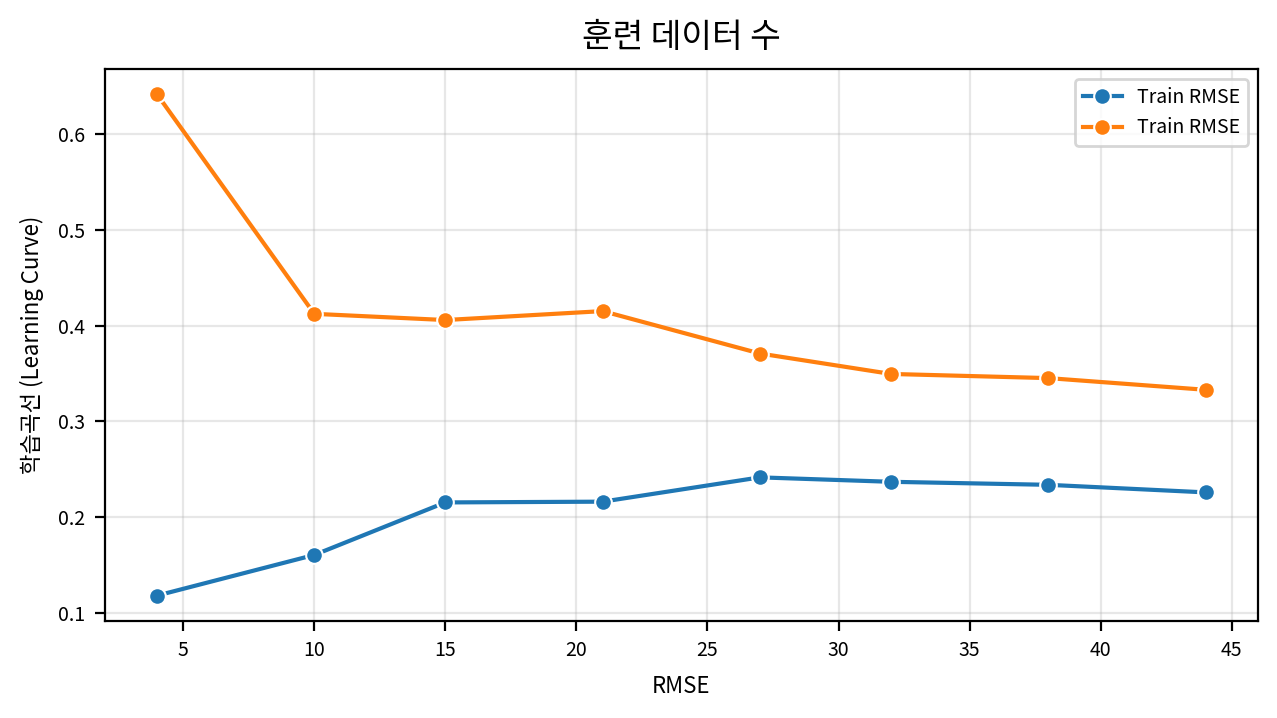

In [7]:
figsize = (1280/ my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize= figsize, dpi=my_dpi)

sb.lineplot(
    x=train_sizes,
    y=train_mean,
    marker="o",
    markeredgecolor = "#ffffff",
    label="Train RMSE",

)
sb.lineplot(
    x=train_sizes,
    y=cv_mean,
    marker="o",
    markeredgecolor = "#ffffff",
    label="Train RMSE",

)

ax.set_title("훈련 데이터 수", fontsize=12, pad=8)
ax.set_xlabel("RMSE", fontsize=8,labelpad=5)
ax.set_ylabel("학습곡선 (Learning Curve)",  fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()
